## CRISP-DM Project - Seattle Air bnb



In [7]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

listings_df = pd.read_csv('listings.csv')
calendar_df = pd.read_csv('calendar.csv')
reviews_df = pd.read_csv('reviews.csv')

In [8]:
listings_num = listings_df.id.count()
host_num = len(listings_df.host_id.unique())
print('How many listings data in listings.csv - {} , How many host in listings.csv - {}'.format(listings_num, host_num))

print('-------------------------------------------------------------------------------------------')

rows_num = calendar_df.shape[0]
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()
print('calendar.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))

print('-------------------------------------------------------------------------------------------')

How many listings data in listings.csv - 3818 , How many host in listings.csv - 2751
-------------------------------------------------------------------------------------------
calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.
-------------------------------------------------------------------------------------------


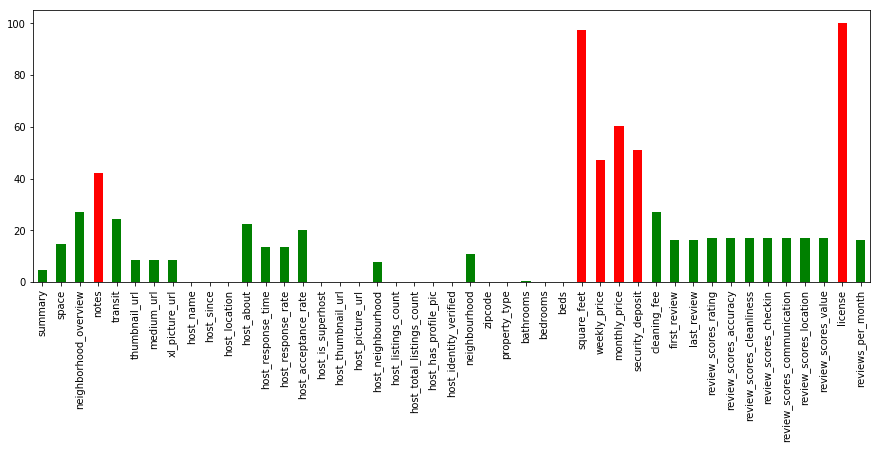

In [9]:
#Visualize the NA values percent from each columns
listings_nullperc_df= listings_df.isnull().mean()*100
listingds_perc_withNan_df = pd.DataFrame(listings_nullperc_df[listings_nullperc_df>0], columns=['null_perc'])
listingds_perc_withNan_df.loc[listingds_perc_withNan_df['null_perc'] >= 40 ,'color'] = 'r'
listingds_perc_withNan_df.loc[listingds_perc_withNan_df['null_perc'] < 40 ,'color'] = 'g'
listingds_perc_withNan_df['null_perc'].plot.bar(figsize = (15,5), color =  listingds_perc_withNan_df['color'])
plt.show()

#Drop column which has more 40% NA value proportion
listings_df.drop(listingds_perc_withNan_df[listingds_perc_withNan_df['color'] == 'r'].index, axis=1, inplace = True)

In [10]:
listings_df.rename(columns={'id':'listing_id'}, inplace = True)

listings_df.drop(['scrape_id', # All same value
                  'last_scraped', # All same value
                  'experiences_offered', # all same value
                  'city', # all same value
                  'market', # all same value
                  'country_code', # all same vaule
                  'country', # all same value
                  'smart_location', # all same value
                  'zipcode', # usless
                  'state', # all same value
                  'street', # usless
                  'has_availability', #all same value
                  'calendar_last_scraped', #all same value
                  'jurisdiction_names', #all same value
                  'host_neighbourhood', #usless
                  'neighbourhood', #usless
                  'neighbourhood_group_cleansed',#usless
                  'requires_license'#all same value
                 ], axis=1, inplace =True)
listings_df.drop(listings_df[[col for col in listings_df.columns if 'url' in col]], axis = 1, inplace=True)

In [11]:
price_col_name= [col for col in listings_df.columns 
                     if ('price' in col) or ('deposit' in col) or ('cleaning_fee' in col) or ('extra_people' in col)]
listings_df[price_col_name] = listings_df[price_col_name].replace(regex=[r'[$,]'], value='').astype(float)

rate_col_name = [col for col in listings_df.columns if 'rate' in col]
listings_df.host_response_rate = listings_df.host_response_rate.replace(regex=[r'[%]'], value='').astype(float)

In [12]:
test = listings_df.dropna(subset=['cleaning_fee'], axis =0).copy()

In [13]:
cat_col_name = [
    'host_response_time', #fill NaN to 0 , change to level
    'property_type',
    'room_type',
    'cancellation_policy'
]

bool_col_name =[
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'is_location_exact',
    'instant_bookable',
    'require_guest_profile_picture',
    'require_guest_phone_verification'
]

num_col_name = [
    'host_acceptance_rate', #fill NaN to 0
    'host_response_rate', #fill NaN to 0
    'calendar_updated',
    'beds',
    'bathrooms',
    'bedrooms',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month',
    'number_of_reviews',
    'host_listings_count',
    'host_total_listings_count',
    'calculated_host_listings_count',
    'latitude',
    'longitude',
    'accommodates',
    'guests_included',
    'minimum_nights',
    'maximum_nights',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365'
]

str_col_name = [
    'name',
    'summary',
    'space',
    'description',
    'neighborhood_overview',
    'transit',
    'host_name',
    'host_location',
    'host_about'
]

date_col_name = [
    'host_since',
    'first_review',
    'last_review'
]



In [14]:
def calendar_updated_convert(_str):
    dic_units = {
        'days': 1,
        'weeks': 7,
        'months': 30
    }
    dic_special = {
        'today':0,
        'yesterday':1,
        'a week':7,
        'naver':900
    }
    for key, value in dic_units.items():
        if key in _str:
            return value * [int(p_str) for p_str in _str.split() if p_str.isdigit()][0]
        else:
            for s_key, s_value in dic_special.items():
                if s_key in _str:
                    return s_value


test.calendar_updated = test.calendar_updated.apply(calendar_updated_convert)

In [15]:
dic_bool = {
    't':True,
    'f':False
}
for col in bool_col_name:
    test.loc[:,col] = test[col].map(dic_bool)
    
dic_cat = {
    'within an hour' : 4,
    'within a few hours' :3,
    'within a day':2,
    'a few days or more':1,
    
    'strict' : 1,
    'moderate' : 2,
    'flexible' : 3,
    
    'Entire home/apt':'entire_h',
    'Private room':'private_r',
    'Shared room':'shared_r',
    
    
    'House':'House',
    'Apartment':'Apartment',
    
    'Townhouse':'Others',
    'Condominium':'Others',
    'Loft':'Others',
    'Bed & Breakfast':'Others',
    'Other':'Others',
    'Cabin':'Others',
    'Bungalow':'Others',
    'Camper/RV':'Others',
    'Boat':'Others',
    'Chalet':'Others',
    'Yurt':'Others',
    'Dorm':'Others'
}
for col in cat_col_name:
    test.loc[:,col] = test[col].map(dic_cat)

In [16]:
test.loc[:,'amenities'] = test.amenities.replace(regex=r'(?:{|}|")',value='').str.split(',')
test.loc[:,'host_verifications'] = test.host_verifications.str.replace('[^\w\s]','').str.split(' ')

In [33]:
def make_freq_table(_series):
    frq_table = {}
    for lst in _series:
        for element in lst:
            if element in frq_table:                
                frq_table[element] +=1
            else:
                frq_table[element] = 1
    return frq_table

dict_host_veri_frq_table = make_freq_table(test.amenities)
df_host_veri_frq_table = pd.DataFrame.from_dict(dict_host_veri_frq_table,
                                                orient = 'index',
                                                columns = ['counts']).sort_values(by = ['counts'],
                                                                                ascending = False)
    
dict_amen_frq_table = make_freq_table(test.host_verifications)
df_amen_frq_table = pd.DataFrame.from_dict(dict_amen_frq_table,
                                           orient='index',
                                           columns=['counts']).sort_values(by = ['counts'],
                                                                                ascending = False)


lst_host_veri_top10 = df_host_veri_frq_table.head(10).index.to_list()
lst_amen_top10 = df_amen_frq_table.head(10).index.to_list()

In [47]:
test[date_col_name].isnull().sum()

host_since        1
first_review    365
last_review     365
dtype: int64

In [268]:
test = listings_df.dropna(subset=['cleaning_fee'], axis =0)

categorical 

'host_response_time',
'property_type',
'room_type',
'cancellation_policy'


numerical 

'host_response_rate',
'calendar_updated',

'beds',
'bathrooms',
'bedrooms',

'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location',
'review_scores_value',
'reviews_per_month',
'number_of_reviews',

'host_listings_count',
'host_total_listings_count',
'calculated_host_listings_count',

'latitude',
'longitude',

'accommodates',

'guests_included',

'minimum_nights',
'maximum_nights',

'availability_30',
'availability_60',
'availability_90',
'availability_365',


boolean 
'host_acceptance_rate',
'host_is_superhost',
'host_has_profile_pic',
'host_identity_verified',
'is_location_exact',
'instant_bookable',
'require_guest_profile_picture',
'require_guest_phone_verification'


'listing_id'
'host_id'

'name',
'summary',
'space',
'description',
'neighborhood_overview',
'transit',
'host_name',
'host_location',
'host_about'

'host_since',
'first_review',
'last_review'

'amenities'
'host_verifications'

'price',
'cleaning_fee',
'extra_people'

In [271]:
test.isnull().sum()[test.isnull().sum() > 0].sort_values()

host_has_profile_pic             1
property_type                    1
host_name                        1
host_since                       1
host_identity_verified           1
host_total_listings_count        1
host_listings_count              1
host_is_superhost                1
host_location                    2
bedrooms                         4
bathrooms                       11
summary                        139
space                          287
host_response_rate             307
host_response_time             307
first_review                   365
last_review                    365
reviews_per_month              365
review_scores_rating           376
review_scores_communication    377
review_scores_cleanliness      378
review_scores_location         380
review_scores_value            381
review_scores_accuracy         382
review_scores_checkin          382
host_acceptance_rate           489
host_about                     538
transit                        607
neighborhood_overvie

In [190]:
test.isnull().sum()[test.isnull().sum() > 0].sort_values().tail(1).index

Index(['neighborhood_overview'], dtype='object')

In [25]:
reviews_df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [26]:
calendar_df.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [15]:
listings_df.columns[2]

'scrape_id'

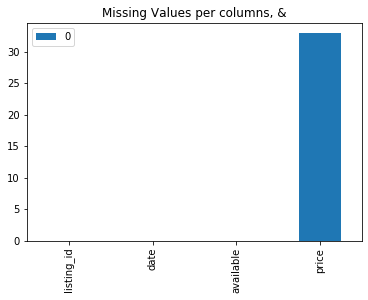

In [24]:
calendar_nullperc_df= calendar_df.isnull().mean()*100
calendar_perc_withNan = pd.DataFrame(calendar_nullperc_df)
calendar_perc_withNan.plot.bar(title='Missing Values per columns, &')
plt.show()

In [46]:
calendar_df.dropna('price',)

Series([], Name: price, dtype: int64)

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
5       $120.00
6        $80.00
7        $60.00
8        $90.00
9       $150.00
10       $95.00
11       $99.00
12      $245.00
13      $165.00
14      $461.00
15      $109.00
16       $66.00
17       $99.00
18      $200.00
19      $700.00
20      $110.00
21       $99.00
22      $450.00
23       $75.00
24      $600.00
25      $450.00
26      $150.00
27       $45.00
28      $300.00
29       $80.00
         ...   
3788    $115.00
3789     $60.00
3790    $175.00
3791     $85.00
3792    $109.00
3793    $109.00
3794    $107.00
3795    $200.00
3796     $85.00
3797     $70.00
3798     $77.00
3799     $65.00
3800    $185.00
3801    $108.00
3802    $200.00
3803    $250.00
3804    $125.00
3805    $100.00
3806    $160.00
3807    $109.00
3808    $175.00
3809    $120.00
3810    $154.00
3811     $65.00
3812     $95.00
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 381

In [51]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [25]:
listings_df.rename(columns={'id':'listing_id'}, inplace = True)
merged_df = pd.merge(listings_df, calendar_df, on ='listing_id')

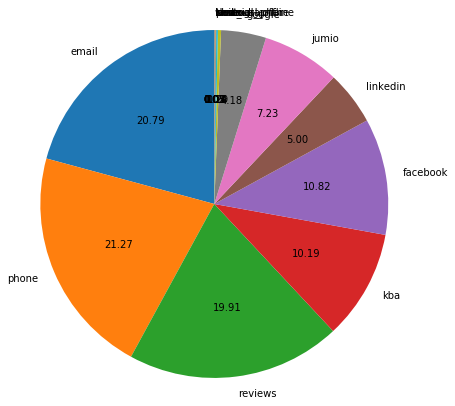

In [26]:
merged_df.loc[:,'host_verifications'] = merged_df.host_verifications.str.replace('[^\w\s]','').str.split(' ')
merged_df.loc[:,'host_verifacitions_count'] = merged_df.host_verifications.map(lambda x : len(x))

host_verification_methode_freq_table = {}
for lst in merged_df.host_verifications:
    for element in lst:
        if element in host_verification_methode_freq_table:                
            host_verification_methode_freq_table[element] +=1
        else:
            host_verification_methode_freq_table[element] =1

plt.pie(host_verification_methode_freq_table.values()
        ,labels=host_verification_methode_freq_table.keys()
        ,autopct='%1.2f'
        ,startangle=90
        ,radius = 2)
plt.show()

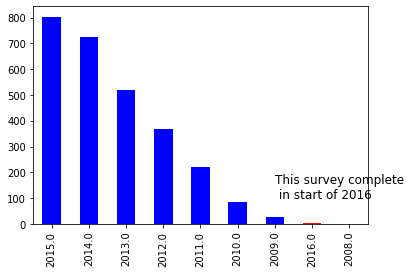

In [27]:
merged_df.loc[:,'host_since'] = pd.to_datetime(merged_df.host_since)
host_since = pd.DataFrame(merged_df[['host_since','host_id']].groupby(['host_id']).first())
host_since.host_since.map(lambda x : x.year).value_counts().plot.bar(color = ['b','b','b','b','b','b','b','r','b'])
plt.text(6, 100, 'This survey complete \n in start of 2016', fontsize=12)
plt.show()

- irrelevant columns candidate list

| Columns Name  | Reason of irrelevance |
| ------------- |-------------|
| host_url      | useless  |
| host_name      | useless  |
| host_location | too complecate       |
| host_about    | long sentence |
| host_thumbnail_url    | useless |
| host_picture_url      | useless |
| calculated_host_listings_count | Idk |
| host_listings_count | same as host_listings_count |
| host_neighbourhood      | Name of Area  |

In [28]:
response_time_map = {
    'within an hour' :1,
    'within a few hours':2,
    'within a day':3,
    'a few dates or more':4
}

acceptance_rate_map ={
    '100%':1,
    '0%':0
}

f_t_map = {
    'f':0,
    't':1
}

merged_df.loc[:,'host_response_time'] = merged_df.host_response_time.map(response_time_map)
merged_df.loc[:,'host_response_rate'] = merged_df.host_response_rate.str.replace('%','').fillna(0).astype(int)
merged_df.loc[:,'host_acceptance_rate'] = merged_df.host_acceptance_rate.map(acceptance_rate_map)
merged_df.loc[:,'host_is_superhost'] = merged_df.host_is_superhost.map(f_t_map)
merged_df.loc[:,'host_has_profile_pic'] = merged_df.host_has_profile_pic.map(f_t_map)
merged_df.loc[:,'host_identity_verified'] = merged_df.host_identity_verified.map(f_t_map)

In [29]:
host_cols_drop_lst = ['host_url',
                      'host_name',
                      'host_location',
                      'host_about',
                      'host_thumbnail_url',
                      'host_picture_url',
                      'calculated_host_listings_count',
                      'host_listings_count',
                      'host_neighbourhood']

same_val_cols_lst = ['experiences_offered',
                     'market',
                     'smart_location',
                     'country',
                     'city',
                     'state',
                     'calendar_last_scraped',
                     'requires_license',
                     'jurisdiction_names']
merged_df.drop(host_cols_drop_lst + same_val_cols_lst, axis = 1, inplace=True)
merged_df.drop(merged_df[[col for col in merged_df.columns if 'url' in col]], axis = 1, inplace=True)
merged_df.drop(merged_df[[col for col in merged_df.columns if 'availability' in col]], axis = 1, inplace=True)

In [30]:
merged_df.columns

Index(['listing_id', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'neighborhood_overview', 'transit', 'host_id',
       'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'zipcode', 'country_code', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price_x', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_

- irrelevant columns candidate list

| Columns Name  | Reason of irrelevance |
| ------------- |-------------|
| name | hosted house title  |
| summary | description column |
| space | description column |
| description | description column |
| experiences_offered | value is only "none" |
| neighborhood_overview | description colum  |
| transit | description column |
| street | street address |
| neighbourhood | name of neighbourhood - we gonna use neighbourhood_group_cleansed or neighbourhood_group_cleansed if we need |
| city | name of city, most data value is 'Seattle' or similiar so usless |
| state | name of state, all value is 'WA' or 'wa'|
| zipcode | useless for anaysis |
| market | market name, All data value is 'Seattle' |
| smart_location | city and state name, most data is 'Seattle, WA' |
| country_code | All data is 'US' |
| country | All data is 'United States' |
| has_availability | All data is 't' |
| availability_30 | |
| availability_60 | |
| availability_90 | |
| availability_365 | |
| calendar_last_scraped | All data is '2016-01-04' |
| requires_license | All data is 't' |
| jurisdiction_names | All data is 'WASHINGTON' |

In [46]:
[col for col in merged_df.columns if 'availability' in col]

['has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365']

In [44]:
merged_df.availability_60.value_counts()

60    337625
0     247105
59     44530
57     33580
55     32120
56     30295
53     28470
52     27740
50     24820
58     24455
54     24090
32     22995
51     22265
49     21900
3      20805
26     20805
48     20805
47     20075
46     20075
44     18615
33     17520
28     15330
43     13140
39     13140
45     12410
42     12045
38     11680
40     11680
4      10585
31     10585
       ...  
27     10220
37      9855
36      9490
5       9490
30      9125
41      9125
35      9125
29      8760
2       8760
25      8030
12      8030
21      8030
20      8030
18      7300
34      7300
24      7300
6       6935
19      6935
14      6570
8       6205
9       6205
23      5840
22      5840
17      5110
13      4380
10      4380
7       4380
16      4015
15      3650
11      3285
Name: availability_60, Length: 61, dtype: int64

In [102]:
merged_df.columns

Index(['listing_id', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview',
       'transit', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price_x',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'c

In [30]:
k = host_analysis[['host_listings_count','host_total_listings_count','listing_count_test']]

In [ ]:
def clean_df(lst_df, cal_df):
    '''
    INPUT
    lst_df - pandas dataframe containing listings data
    cal_df - pandas dataframe containing calender data
    
    OUTPUT
    df - cleaned dataset, merged with both input data frames;
    1. irrelevant columns are dropped.
    '''
    lst_df.rename(columns={'id':'listing_id'}, inplace = True)
    merge_df = pd.merge(lst_df, cal_df, on ='listing_id')
    columns_to_drop = listingd_perc_withnan_df[listingd_perc_withnan_df['color'] == 'r'].index.tolist()
    

In [33]:
k[k['listing_count_test'] < 0]

,host_listings_count,host_total_listings_count,listing_count_test


In [16]:
listings_df[listingd_perc_withnan_df.index.values.tolist()].columns

TypeError: all inputs must be Index

In [8]:
df_num_lst = df_listings.select_dtypes(include=['int64', 'float64']).copy()
df_cat_lst = df_listings.select_dtypes(include=['object']).copy()

NameError: name 'df_listings' is not defined

In [4]:
df_num_lst.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

Text(0, 0.5, 'count')

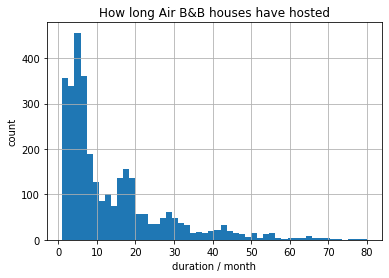

In [23]:
df_num_lst['op_duration_month'] = df_num_lst['number_of_reviews'] / df_num_lst['reviews_per_month']
df_num_lst.op_duration_month.hist(bins =50)
plt.title('How long Air B&B houses have hosted')
plt.xlabel('duration / month')
plt.ylabel('count')

In [53]:
for i in df_num_lst.columns[7:]:
    df_num_lst[i].value_counts())

2     1627
4      785
3      398
6      332
1      256
5      184
8      119
7       52
10      25
12      15
9       13
16       4
11       3
14       3
15       2
Name: accommodates, dtype: int64
1.0    2882
2.0     373
1.5     248
2.5     124
3.0      64
3.5      57
0.5      31
0.0       8
4.0       8
4.5       3
5.0       2
8.0       2
Name: bathrooms, dtype: int64
1.0    2417
2.0     640
0.0     372
3.0     283
4.0      69
5.0      24
6.0       6
7.0       1
Name: bedrooms, dtype: int64
1.0     2201
2.0      912
3.0      433
4.0      152
5.0       73
6.0       21
7.0       14
8.0        4
9.0        4
10.0       2
15.0       1
Name: beds, dtype: int64
1200.0    8
800.0     7
1300.0    5
0.0       5
750.0     4
650.0     4
500.0     4
1.0       3
1000.0    3
250.0     3
550.0     3
600.0     2
2100.0    2
3000.0    2
900.0     2
450.0     2
1800.0    2
2.0       2
1150.0    2
300.0     2
2000.0    2
1600.0    2
1400.0    2
850.0     1
200.0     1
3.0       1
1850.0    1
950.0     1

most of house is for under 2-people